# TESTE 1

Este notebook usa os dados (bronze) extraídos da API do Olho Vivo referentes ao dia 30/12/2026, que podem ser encontrados neste link: [https://cloudprodamazhotmail-my.sharepoint.com/:u:/r/personal/oliviaamann_prefeitura_sp_gov_br/Documents/ADPPSP/bloomberg/run%20de%20ano%20novo/dia%2030.zip?csf=1&web=1&e=wFzLTP]

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.load_csv import load_csv

def manual_data_path(file_name)->str:
    path = os.path.join(
        'data',
        'manual_data',
        file_name
    )
    return path

In [2]:
#carregando arquivo: onibus-a-diesel-diario_2025-12-30_silver -> eu errei fui mlk
onibus_diesel_dia30 = pd.read_csv(
    os.path.join(
        'data',
        'manual_data',
        'calculo-emissao-poluentes-diario_2025-12-30_silver.csv'
    )
)

onibus_diesel_dia31= pd.read_csv(manual_data_path('calculo-emissao-poluentes-diario_2025-12-31_silver.csv'))
onibus_diesel_dia01= pd.read_csv(manual_data_path('calculo-emissao-poluentes-diario_2026-01-01_silver.csv'))

# Dados e Cálculo de Médias

In [3]:
# Médias
list_dados = [
    (onibus_diesel_dia30, 30),
    (onibus_diesel_dia31, 31),
    (onibus_diesel_dia01, 1)
]

df_dados_dia = pd.DataFrame(
    columns=['dia', 'n_frota', 'total_co2_t', 'co2_media', 'mp_media', 'nox_media',]
)

for df, dia in list_dados:
    n_frota= df['codigo_onibus'].nunique() #len(unique)
    total_co2=df['emissao_co2'].sum() /1000 #toneladas
    co2_media=df['emissao_co2'].mean()
    mp_media= df['emissao_mp'].mean()
    nox_media = df['emissao_nox'].mean()

    
    df_dados_dia.loc[len(df_dados_dia)] = [
        dia,
        n_frota,
        total_co2,
        co2_media,
        mp_media,
        nox_media
    ]

todos_frota_media = df_dados_dia['n_frota'].mean().astype(int)
todos_co2_media= df_dados_dia['co2_media'].mean() 
todos_mp_media= df_dados_dia['mp_media'].mean()
todos_nox_media= df_dados_dia['nox_media'].mean()
print(
    f'''
    CO2: {round(todos_co2_media, 3)} Kg
    MP: {round(todos_mp_media, 3)} g
    NOx: {round(todos_nox_media, 3)} g
    Frota média: {todos_frota_media}
    '''
)
print(df_dados_dia)


    CO2: 257.627 Kg
    MP: 1.052 g
    NOx: 2.365 g
    Frota média: 8407
    
    dia  n_frota  total_co2_t   co2_media  mp_media  nox_media
0  30.0  10947.0  2555.809543  233.471229  0.980509   2.167026
1  31.0   7842.0  2020.250065  257.619238  1.057921   2.313529
2   1.0   6434.0  1813.038569  281.790266  1.116227   2.615777


Antes de fazer as coisas do Caio, vou fazer coisinhas que NÃO PRECISAM IR PRO PESSOAL LÁ DO BY IF
## Analises pra mim
1) Média de frota diária
2) Média de Emissão de poluentes


OBS: só o total diário de CO2 está em toneladas, pq eu queria ver se realmente emitia tanto... e meio que emite

In [4]:
list_dados = [
    (onibus_diesel_dia30, 30),
    (onibus_diesel_dia31, 31),
    (onibus_diesel_dia01, 1)
]

df_dados_dia = pd.DataFrame(
    columns=['dia', 'n_frota', 'total_co2_t', 'co2_media', 'mp_media', 'nox_media',]
)

for df, dia in list_dados:
    n_frota= df['codigo_onibus'].nunique() #len(unique)
    total_co2=df['emissao_co2'].sum() /1000 #toneladas
    co2_media=df['emissao_co2'].mean()
    mp_media= df['emissao_mp'].mean()
    nox_media = df['emissao_nox'].mean()

    
    df_dados_dia.loc[len(df_dados_dia)] = [
        dia,
        n_frota,
        total_co2,
        co2_media,
        mp_media,
        nox_media
    ]

df_dados_dia

,dia,n_frota,total_co2_t,co2_media,mp_media,nox_media
0,30.0,10947.0,2555.809543,233.471229,0.980509,2.167026
1,31.0,7842.0,2020.250065,257.619238,1.057921,2.313529
2,1.0,6434.0,1813.038569,281.790266,1.116227,2.615777


In [5]:
todos_frota_media = df_dados_dia['n_frota'].mean().astype(int)
todos_co2_media= df_dados_dia['co2_media'].mean() 
todos_mp_media= df_dados_dia['mp_media'].mean()
todos_nox_media= df_dados_dia['nox_media'].mean()
print(
    f'''
    CO2: {round(todos_co2_media, 3)} Kg
    MP: {round(todos_mp_media, 3)} g
    NOx: {round(todos_nox_media, 3)} g
    '''
)


    CO2: 257.627 Kg
    MP: 1.052 g
    NOx: 2.365 g
    


OBS: a meta do programa de metas é de substituir 2k200 onibus

## Simulação de Monte Carlo

### Dúvidas:
1) wtf é o gdf_final.csv???? -> R: já vi, são os onibus sem os elétricos
2) O que é o `Y` no `sim_monte_carlo()`?



### Cópia do código do Caio

In [6]:
df_diesel = onibus_diesel_dia30

In [7]:
def sim_monte_carlo(df_diesel, Y, N=2000, dias=365):
    
    resultados_diarios = []

    for _ in range(N):
        amostra = df_diesel.sample(n=Y, replace=False)
        emissao_total = amostra["emissao_co2"].sum()
        resultados_diarios.append(emissao_total)

    resultados_diarios = np.array(resultados_diarios)
    resultados_acumulados = resultados_diarios * dias

    impacto_medio = resultados_diarios.mean()
    impacto_maximo = df_diesel.nlargest(Y, "emissao_co2")["emissao_co2"].sum()
    impacto_diferenca = impacto_maximo - impacto_medio

    IC_inf = np.percentile(resultados_diarios, 2.5)
    IC_sup = np.percentile(resultados_diarios, 97.5)

    return {
        "Y": Y,
        "dias": dias,
        "impacto_medio_dia": impacto_medio,
        "IC_inf_dia": IC_inf,
        "IC_sup_dia": IC_sup,
        "impacto_maximo_dia": impacto_maximo,
        "impacto_diferenca_dia": impacto_diferenca,
        "impacto_medio_acumulado": resultados_acumulados.mean(),
        "IC_inf_acumulado": np.percentile(resultados_acumulados, 2.5),
        "IC_sup_acumulado": np.percentile(resultados_acumulados, 97.5),
        "resultados_diarios": resultados_diarios,
        "resultados_acumulados": resultados_acumulados
    }

In [8]:
def estimar_frota_para_meta(
    df_diesel,
    meta_emissao,
    N=2000,
    Y_min=10,
    Y_max=500,
    passo=100
):

    resultados_meta = []

    for Y in range(Y_min, Y_max + 1, passo):
        sim = sim_monte_carlo(df_diesel, Y, N=N)

        valor = sim["impacto_medio_dia"]

        resultados_meta.append({
            "Y": Y,
            "impacto_estimado_medio": valor
        })

        if valor >= meta_emissao:
            break

    return pd.DataFrame(resultados_meta)

In [9]:
meta = 1  # t CO2 por dia

df_meta = estimar_frota_para_meta(
    df_diesel,
    meta_emissao=meta
)

display(df_meta.tail())

,Y,impacto_estimado_medio
0,10,2297.554163


In [10]:
tamanhos_frota = [50, 100, 200]
dias_projecao = 365

res = [
    sim_monte_carlo(df_diesel, y, dias=dias_projecao)
    for y in tamanhos_frota
]

In [11]:
tabela_resumo = pd.DataFrame([
    {
        "Y": r["Y"],
        "Emissão média evitada (t CO2/dia)": r["impacto_medio_dia"],
        "IC95% inf (dia)": r["IC_inf_dia"],
        "IC95% sup (dia)": r["IC_sup_dia"],
        "Cenário máximo (t CO2/dia)": r["impacto_maximo_dia"],
        "Emissão média acumulada (t CO2)": r["impacto_medio_acumulado"]
    }
    for r in res
]).round(4)

display(tabela_resumo)

,Y,Emissão média evitada (t CO2/dia),IC95% inf (dia),IC95% sup (dia),Cenário máximo (t CO2/dia),Emissão média acumulada (t CO2)
0,50,11730.4027,9378.1238,15779.3457,126026.5033,4.281597e+06
1,100,23284.5919,19836.9534,29105.2226,171932.5130,8.498876e+06
2,200,46732.6694,41375.7484,56675.8142,247136.7581,1.705742e+07


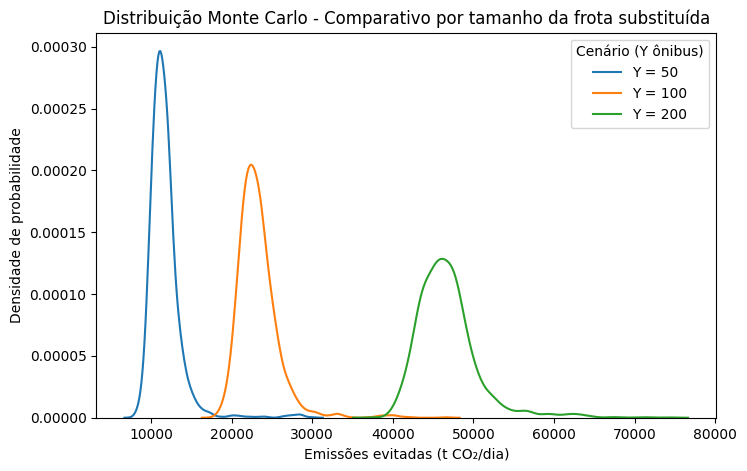

In [12]:
plt.figure(figsize=(8,5))
for r in res:
    sns.kdeplot(
        r["resultados_diarios"],
        label=f"Y = {r['Y']}"
    )

plt.xlabel("Emissões evitadas (t CO₂/dia)")
plt.ylabel("Densidade de probabilidade")
plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
plt.legend(title="Cenário (Y ônibus)")
plt.show()

Dados de teste do Dagster

In [13]:
#ORIGINALMENTE: calculo-distancia-percorrida_2025-12-30_silver.csv
df_posicoes_d1 = pd.read_csv(manual_data_path("calculo-emissao-poluentes-diario_2025-12-30_silver.csv"))
df_posicoes_d2 = pd.read_csv(manual_data_path("calculo-emissao-poluentes-diario_2025-12-30_silver.csv"))
df_posicoes_d3 = pd.read_csv(manual_data_path("calculo-emissao-poluentes-diario_2025-12-30_silver.csv"))


In [14]:
df_posicoes = pd.concat([df_posicoes_d1, df_posicoes_d2, df_posicoes_d3], ignore_index=True)

In [15]:
#consumo diesel

In [16]:
#deslocamento e ar

In [17]:
#tipo onibus

#fator consumo


#consumo co2


In [18]:
def sim_monte_carlo(df_posicoes, Y, N=2000, seed=42):
    np.random.seed(seed)
    resultados = []

    for _ in range(N):
        amostra = df_posicoes.sample(n=Y, replace=False)
        emissao_total = amostra["emissao_co2"].sum()
        resultados.append(emissao_total)

    impacto_medio = np.mean(resultados)
    impacto_maximo = df_posicoes.nlargest(Y, "emissao_co2")["emissao_co2"].sum()
    impacto_diferenca = impacto_maximo - impacto_medio
    IC_inf = np.percentile(resultados, 2.5)
    IC_sup = np.percentile(resultados, 97.5)

    return {
        "Y": Y,
        "impacto_medio": impacto_medio,
        "IC_inf": IC_inf,
        "IC_sup": IC_sup,
        "impacto_maximo": impacto_maximo,
        "impacto_diferenca": impacto_diferenca,
        "resultados": resultados
    }

In [19]:
tamanhos_frota = [50, 100, 200]
res = [sim_monte_carlo(df_posicoes, y) for y in tamanhos_frota]

PS.: Actually não está em toneladas aqui não

In [20]:
tabela_resumo = pd.DataFrame([
    {
        "Tamanho da frota substituída (Y)": r["Y"],
        "Emissão média evitada (t CO₂/no período)": r["impacto_medio"],
        "IC95% inferior": r["IC_inf"],
        "IC95% superior": r["IC_sup"],
        "Cenário máximo (t CO₂/no período)": r["impacto_maximo"],
        "Diferença (Máx - Média)": r["impacto_diferenca"]
    }
    for r in res
])

tabela_resumo = tabela_resumo.round(5)
tabela_resumo = tabela_resumo.sort_values(by="Tamanho da frota substituída (Y)")

print("\nResumo dos resultados da Simulação de Monte Carlo")
print("=" * 90)
display(tabela_resumo)


Resumo dos resultados da Simulação de Monte Carlo


,Tamanho da frota substituída (Y),Emissão média evitada (t CO₂/no período),IC95% inferior,IC95% superior,Cenário máximo (t CO₂/no período),Diferença (Máx - Média)
0,50,11616.93458,9418.28735,15179.55735,236667.96152,225051.02694
1,100,23356.27923,19840.86186,29082.85705,319812.61789,296456.33866
2,200,46634.41420,41434.24345,56998.98378,427276.83190,380642.41770


In [21]:
#plt.figure(figsize=(8,5))
#for r in res:
    #sns.kdeplot(r["resultados"], label=f"Y = {r['Y']}")
#plt.xlabel("Emissões evitadas (t CO₂/no período)")
#plt.ylabel("Densidade de probabilidade")
#plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
#plt.legend(title="Cenário (Y ônibus)")
#plt.show()

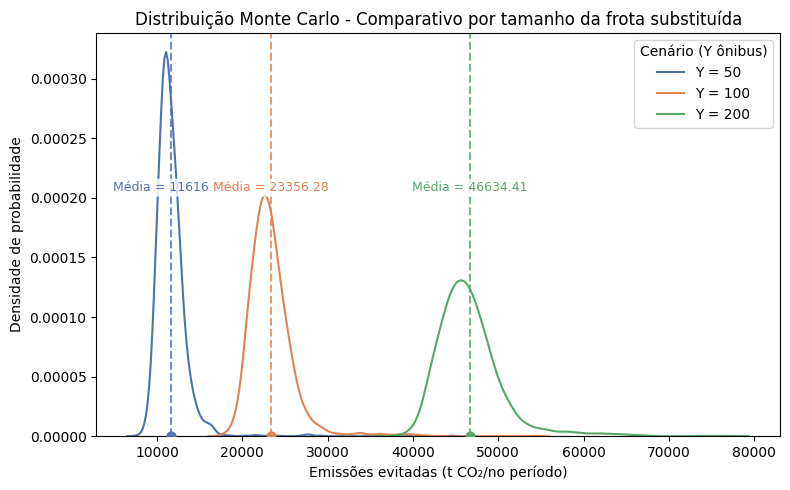

In [22]:
plt.figure(figsize=(8,5))

cores = sns.color_palette("deep", len(res))

for i, r in enumerate(res):
    sns.kdeplot(r["resultados"], label=f"Y = {r['Y']}", color=cores[i])
    
    media = np.mean(r["resultados"])
    
    plt.axvline(media, linestyle='--', color=cores[i], alpha=0.8)
    
    plt.scatter(media, 0, color=cores[i], s=40, zorder=5)
    
    plt.text(media, plt.ylim()[1]*0.6,  
             f"Média = {media:.2f}",  
             ha='center', va='bottom', color=cores[i],
             fontsize=9, rotation=0,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

plt.xlabel("Emissões evitadas (t CO₂/no período)")
plt.ylabel("Densidade de probabilidade")
plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
plt.legend(title="Cenário (Y ônibus)")
plt.tight_layout()
plt.show()


In [23]:
#CORRIGIR ORDEM POR HORA GPS
##df_posicoes["hora_gps"] = pd.to_datetime(df_posicoes["hora_gps"])
##df_posicoes = df_posicoes.sort_values("hora_gps").reset_index(drop=True)

#FAZER UM MAPA PRA CADA DIA
##dias_unicos = df_posicoes["hora_gps"].dt.date.unique()
##mapa_dias = {d: f"dia {i+1}" for i, d in enumerate(dias_unicos)}
##df_posicoes["dia"] = df_posicoes["hora_gps"].dt.date.map(mapa_dias)

In [24]:
df_posicoes.head()

,codigo_onibus,distancia_percorrida,segundos_deslocamento,tecnologia,fase_conama,fator_consumo_l,fator_consumo_kg,consumo_l,consumo_kg,emissao_co2,emissao_mp,emissao_nox
0,3117,4.266481e+06,48638.0,Biarticulado,P8,0.90,0.756,3839.833239,3225.459920,10256.194580,0.083862,3.586711
1,3118,3.863984e+03,2282.0,Articulado (18m),P8,0.80,0.672,3.091187,2.596597,8.256562,0.000068,0.002887
2,3203,1.207305e+05,30293.0,Biarticulado,P7,0.90,0.756,108.657489,91.272291,290.224153,0.050200,6.001153
3,5120,1.124584e+05,32531.0,Articulado (18m),P8,0.80,0.672,89.966713,75.572039,240.301091,0.001965,0.084036
4,5218,3.639870e+02,2540.0,Básico,P7,0.53,0.445,0.192913,0.161974,0.515271,0.000089,0.010650


In [25]:
df_posicoes["emissao_co2"].describe()

count    32841.000000
mean       233.471229
std        274.942442
min          0.000000
25%        124.204122
50%        196.851957
75%        293.838790
max      16649.591770
Name: emissao_co2, dtype: float64

# Samples e visualizações

In [26]:
onibus_diesel_dia31.columns

Index(['codigo_onibus', 'distancia_percorrida', 'segundos_deslocamento',
       'tecnologia', 'fase_conama', 'fator_consumo_l', 'fator_consumo_kg',
       'consumo_l', 'consumo_kg', 'emissao_co2', 'emissao_mp', 'emissao_nox'],
      dtype='str')

In [27]:
todos_frota_media

np.int64(8407)

In [28]:
todos_co2_media

np.float64(257.6269108665552)

In [29]:
df_posicoes.columns

Index(['codigo_onibus', 'distancia_percorrida', 'segundos_deslocamento',
       'tecnologia', 'fase_conama', 'fator_consumo_l', 'fator_consumo_kg',
       'consumo_l', 'consumo_kg', 'emissao_co2', 'emissao_mp', 'emissao_nox'],
      dtype='str')